<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_projects/blob/main/Project_Finance_Summery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Currency Exchange Rates
This short study focuses on forecasting the exchange rates of the PRC Renminbi (CNY) and the Singapore Dollar (SGD) against the US Dollar (USD) over the next three months. For this purpose, I experimented with numerous supervised and unsupervised models; however, the analysis ultimately employed the comparatively simple and computationally efficient SARIMAX and auto_arima models.

Initial analysis suggests that the People’s Bank of China (PBoC) maintained an undervalued exchange rate for the Renminbi (RMB) until mid-2005, when it began a gradual transition towards a managed-floating regime. This shift, accelerated after partial liberalisation in subsequent years, allowed the RMB to respond more closely to underlying market forces, in a manner akin to a system dynamically adjusting to real economic inputs [1, 2, 3]. Consequently, for reliable forecasting purposes, only data from post-summer 2016 was deemed suitable for model training and evaluation - albeit with caution.

Both my empirical results and the broader literature indicate that movements in the Renminbi (RMB) of the People’s Republic of China (PRC) exert a substantial influence on the value of the Singapore dollar (SGD). Consequently, the earlier SARIMAX model developed for forecasting the SGD was specified with approximately 80 per cent of its explanatory power derived from the RMB, and the remaining 20 per cent allocated to other key economic partners of Singapore (Project_Finance file). Given Singapore’s relatively small but affluent, banking-oriented economy and its extensive trade and financial linkages with the PRC, this modelling assumption is well-founded [4, 5, 6, 7].

The dataset presents particular challenges for predictive modelling due to its limited length and pronounced seasonality. Distinct seasonal patterns are evident: the Renminbi (RMB) of the People’s Republic of China (PRC) typically appreciates over the course of the year, reflecting the country’s substantial exports of low-cost goods to the United States. Conversely, during late summer, the RMB often depreciates as the PRC undertakes large-scale imports - most notably soybeans in August, followed by crude oil and natural gas from late August through early November - from the United States. These trade flows generate temporary upward pressure on the USD relative to the RMB [8, 9, 10].

In a previous semi-empirical SARIMAX model - developed following a detailed literature review and the seasonal adjustment strategy described in the Project_Finance file - I successfully forecast the value of the renminbi (RMB) for the next three months, achieving a mean absolute percentage error (MAPE) of 0.67. This accuracy is acceptable and broadly in line with the results of comparable modeling approaches in the literature [11, 12, 13].

As an alternative modelling strategy (also described in Yuan_part2), I attempted to invert the approach - first predicting SGD, then inferring CNY based on its historical correlation. However, this reverse model proved unsuccessful. The inverse relationship appeared too complex to capture accurately without either significantly more data (e.g., on soybean and oil prices) or a substantially more computationally intensive modelling framework [14, 15].

## In this part of my research
 I applied the computationally efficient Auto-ARIMA model. Initially, I tested its robustness by training the model on my EDA data from 01 July 2016 to 01 July 2019, and subsequently used it to predict the PRC yuan over the period from 01 October 2019 to 01 January 2020. Despite a three-month gap between the end of the training data and the start of the test set, the Auto-ARIMA model yielded surprisingly strong results, with an error margin of only 2.5%.

Furthermore, I applied the Auto-ARIMA model to the most recent data, including the validation set. The training period spanned from 01 July 2016 to 01 October 2019, after which I predicted the PRC yuan. The result was a 2.2% gap, which is acceptable for a three-month ahead forecast. Subsequently, I trained another Auto-ARIMA model on the same time period for the Singapore dollar, achieving an impressive error rate of only 1.2% [16, 17].

--------------------------------------------------------------------------------

# Libraries

## general

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc # gc.collect() for rubbish collection

## modeling

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [ ]:
#!pip install --no-cache-dir --upgrade numpy==1.26.4 pmdarima

In [ ]:
import pmdarima as pm
from pmdarima import auto_arima

--------------------------------------------------------------------------------

# Data

## download and initial transform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_or = pd.read_csv('/content/drive/MyDrive/MasterSchool/Project/Foreign_Exchange_Rates.csv', sep=';')
df_or.shape

(5217, 3)

In [ ]:
df_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   DATE                              5217 non-null   object
 1   SINGAPORE - SINGAPORE DOLLAR/US$  5217 non-null   object
 2   CHINA - YUAN/US$                  5217 non-null   object
dtypes: object(3)
memory usage: 122.4+ KB


In [ ]:
df_or.sample(2)

,DATE,SINGAPORE - SINGAPORE DOLLAR/US$,CHINA - YUAN/US$
3805,2014-08-04,1.2461,6.178
3269,2012-07-13,1.2651,6.3789


In [ ]:
df = df_or.copy()

Convert data to datetime, downcast numerics to float, and set the datetime column as the index

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d', errors='coerce')
df['SINGAPORE - SINGAPORE DOLLAR/US$'] = pd.to_numeric(df['SINGAPORE - SINGAPORE DOLLAR/US$'], errors='coerce', downcast='float')
df['CHINA - YUAN/US$'] = pd.to_numeric(df['CHINA - YUAN/US$'], errors='coerce', downcast='float')


df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

df.head()

,SINGAPORE - SINGAPORE DOLLAR/US$,CHINA - YUAN/US$
DATE,,
2000-01-03,1.6563,8.2798
2000-01-04,1.6535,8.2799
2000-01-05,1.6560,8.2798
2000-01-06,1.6655,8.2797
2000-01-07,1.6625,8.2794


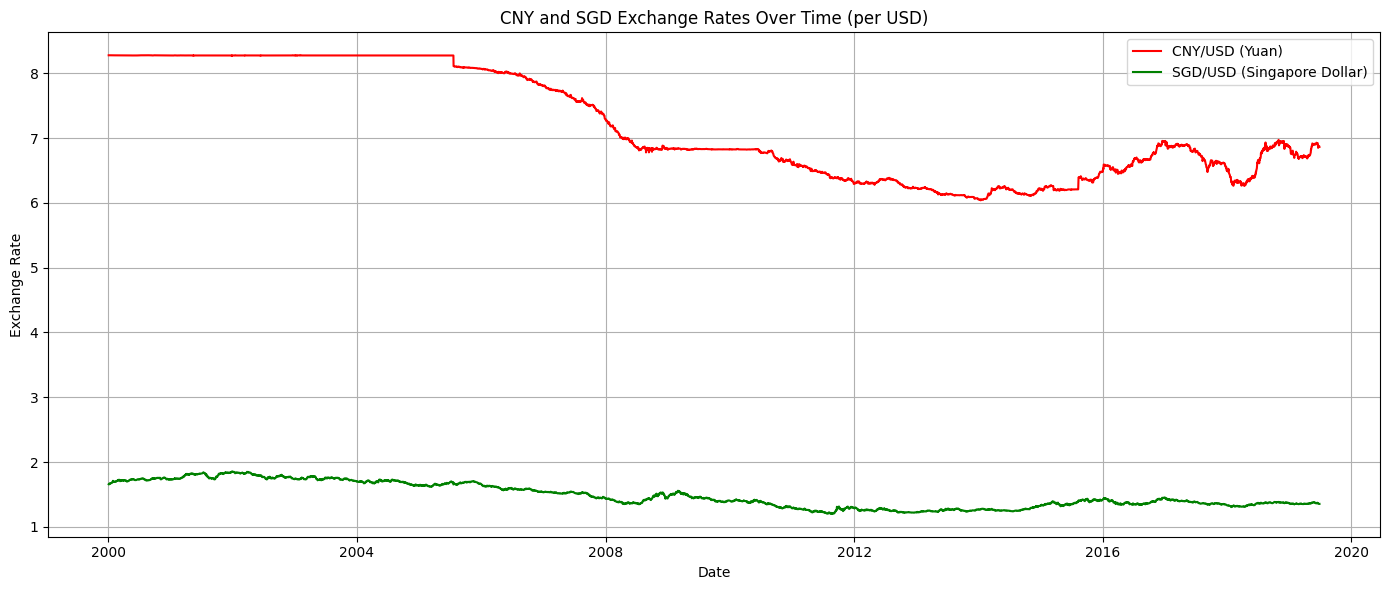

In [ ]:
df_filtered = df[df.index < '2019-07-01'][['CHINA - YUAN/US$', 'SINGAPORE - SINGAPORE DOLLAR/US$']].dropna(how='all')

plt.figure(figsize=(14, 6))
plt.plot(df_filtered.index, df_filtered['CHINA - YUAN/US$'], label='CNY/USD (Yuan)', color='red')
plt.plot(df_filtered.index, df_filtered['SINGAPORE - SINGAPORE DOLLAR/US$'], label='SGD/USD (Singapore Dollar)', color='green')

plt.title('CNY and SGD Exchange Rates Over Time (per USD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Partition the dataset into training, validation, and test subsets

In [ ]:
df_train = df[df.index < '2019-07-01']
df_val = df[(df.index >= '2019-07-01') & (df.index < '2019-10-01')]
df_test = df[df.index >= '2019-10-01']

In [ ]:
gc.collect()

3590

--------------------------------------------------------------------------------

# Exploratory Data Analysis (EDA)

## Overview of the PRC Economy and Scope of Analysis

The People’s Republic of China (PRC) is the world’s second-largest economy, characterised by rapid industrialisation, export-led growth, and increasing domestic consumption. Since initiating market-oriented reforms in the late 1970s, China has transformed from an agrarian economy into a global manufacturing and technological powerhouse. Its economic expansion has been supported by strong state involvement, extensive infrastructure investment, and a large, increasingly skilled labour force.

The Chinese renminbi (RMB), also known as the yuan, has historically been tightly managed by the People’s Bank of China (PBOC). For much of the early 2000s, the yuan was pegged to the US dollar at an artificially low rate to boost export competitiveness. While gradual liberalisation efforts began in the late 2000s, meaningful adjustments to the currency regime became more visible around 2012, including increased flexibility in the exchange rate mechanism and broader internationalisation of the RMB.

For the purpose of this analysis, I will focus on the period from **July 2016** onward, as prior to this, the yuan’s valuation was heavily distorted by state controls. Studying the post-2016 period allows for a more meaningful assessment of how the currency reflects underlying economic forces, relative to a gradually more market-influenced environment [1,2, 3].

The People’s Republic of China is Singapore’s largest trading partner; consequently, the Singapore dollar is strongly influenced by the Chinese yuan. Accordingly, this study forecasts the SGD based on the yuan’s value, with all references documented in prior research file [5].

In [ ]:
df_eda = df_train.loc['2016-07-01':]
gc.collect()

0

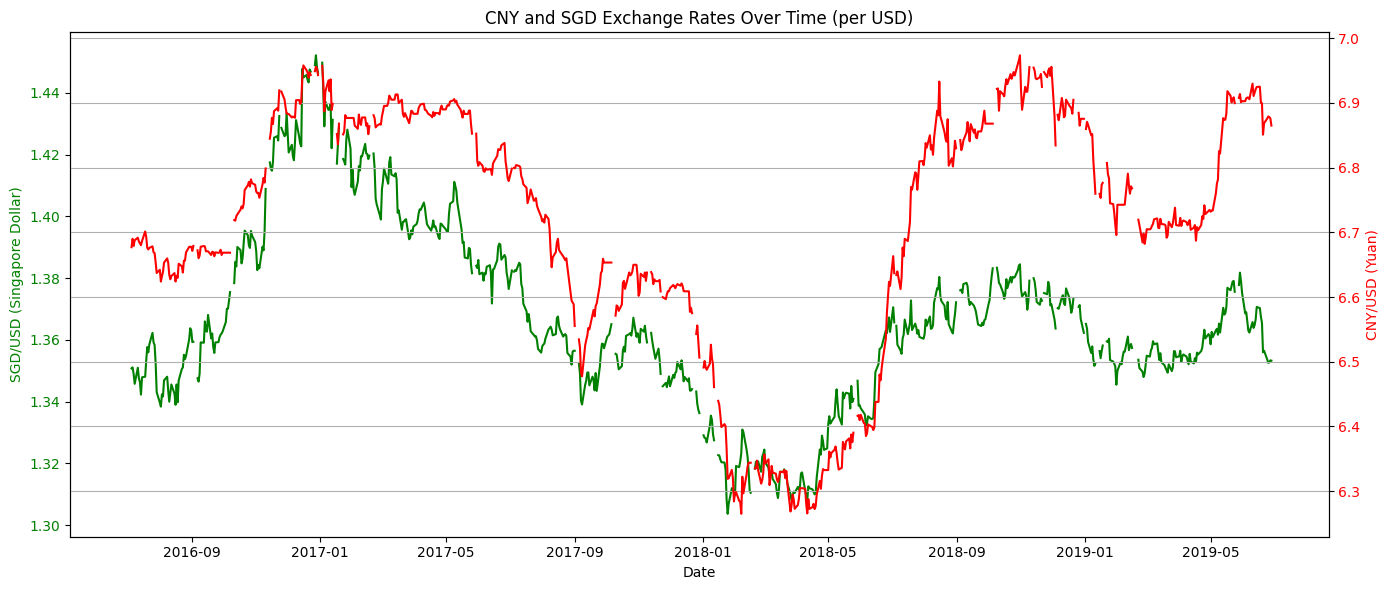

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color_sgd = 'green'
ax1.set_xlabel('Date')
ax1.set_ylabel('SGD/USD (Singapore Dollar)', color=color_sgd)
ax1.plot(df_eda.index, df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'], color=color_sgd, label='SGD/USD')
ax1.tick_params(axis='y', labelcolor=color_sgd)

ax2 = ax1.twinx()
color_cny = 'red'
ax2.set_ylabel('CNY/USD (Yuan)', color=color_cny)
ax2.plot(df_eda.index, df_eda['CHINA - YUAN/US$'], color=color_cny, label='CNY/USD')
ax2.tick_params(axis='y', labelcolor=color_cny)

plt.title('CNY and SGD Exchange Rates Over Time (per USD)')
fig.tight_layout()
plt.grid(True)
plt.show()

Gaps are deliberately retained as NaN values to indicate periods when no currency trading occurred

## Two-week smoothing -
quite well and clearly reveals that the seasonal trend of the PRC yuan markedly influences that of the Singapore dollar; therefore, forecasting the SGD necessitates first predicting the yuan

In [ ]:
sgd_2weeks = df_eda['SINGAPORE - SINGAPORE DOLLAR/US$']\
    .resample('W-MON')\
    .interpolate(method='linear', limit_direction='both')\
    .rolling(window=2, center=True).mean()

cny_2weeks = df_eda['CHINA - YUAN/US$']\
    .resample('W-MON')\
    .interpolate(method='linear', limit_direction='both')\
    .rolling(window=2, center=True).mean()

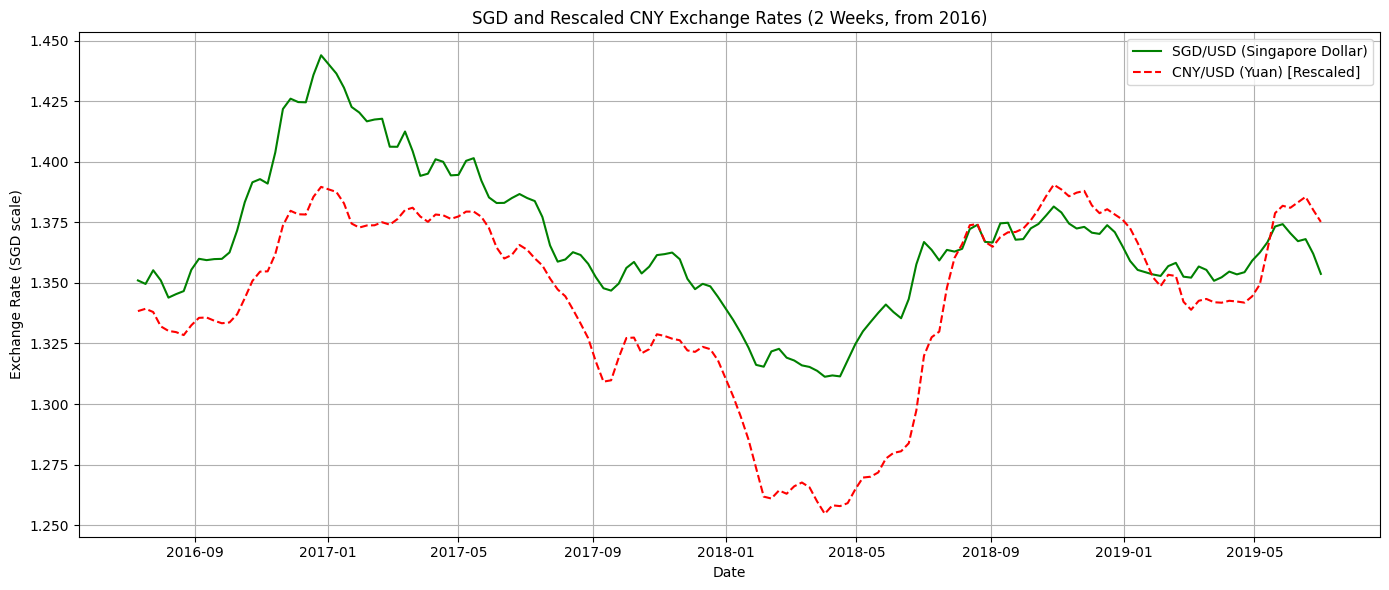

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(sgd_2weeks.index, sgd_2weeks, label='SGD/USD (Singapore Dollar)', color='green')
plt.plot(cny_2weeks.index, cny_2weeks / 5, label='CNY/USD (Yuan) [Rescaled]', color='red', linestyle='--')

plt.title('SGD and Rescaled CNY Exchange Rates (2 Weeks, from 2016)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (SGD scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sgd_weekly = df_eda['SINGAPORE - SINGAPORE DOLLAR/US$']\
    .resample('W-MON').interpolate(method='linear', limit_direction='both')

cny_weekly = df_eda['CHINA - YUAN/US$']\
    .resample('W-MON').interpolate(method='linear', limit_direction='both')

sgd_2weeks = sgd_weekly.rolling(window=2, center=True).mean().dropna()
cny_2weeks = cny_weekly.rolling(window=2, center=True).mean().dropna()

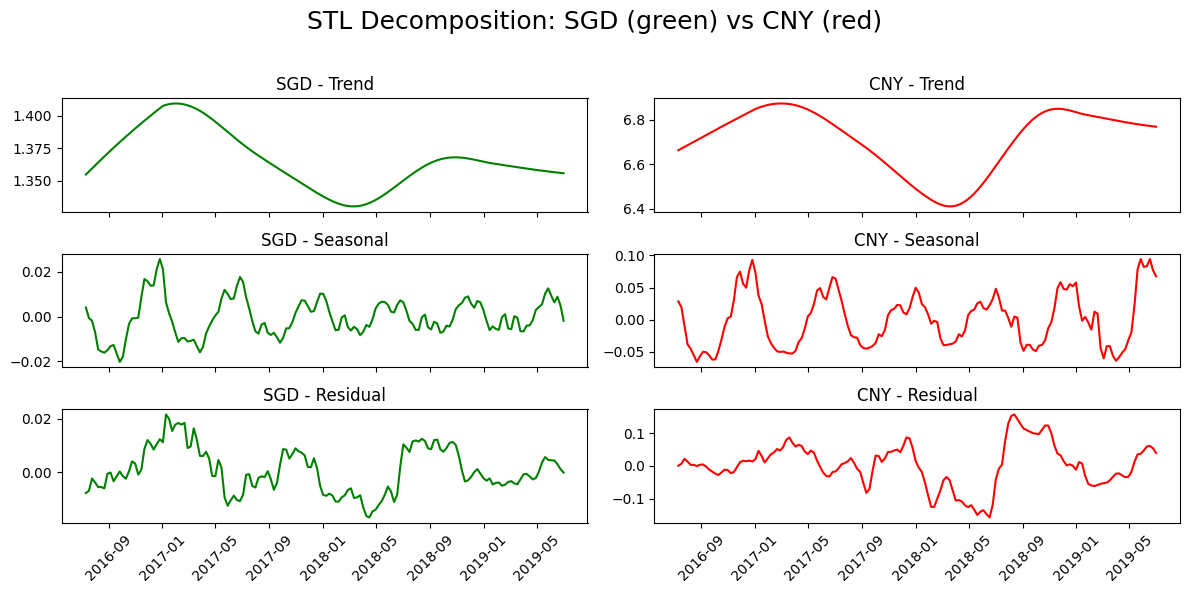

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6), sharex=True)
fig.suptitle('STL Decomposition: SGD (green) vs CNY (red)', fontsize=18)

if not sgd_2weeks.empty:
    stl_sgd = STL(sgd_2weeks, period=26)
    result_sgd = stl_sgd.fit()

    axes[0, 0].plot(result_sgd.trend, color='green')
    axes[0, 0].set_title('SGD - Trend')
    axes[1, 0].plot(result_sgd.seasonal, color='green')
    axes[1, 0].set_title('SGD - Seasonal')
    axes[2, 0].plot(result_sgd.resid, color='green')
    axes[2, 0].set_title('SGD - Residual')
    axes[2, 0].tick_params(axis='x', rotation=45)
else:
    print("sgd_2weeks is empty. Cannot perform STL decomposition.")

if not cny_2weeks.empty:
    stl_cny = STL(cny_2weeks, period=26)
    result_cny = stl_cny.fit()

    axes[0, 1].plot(result_cny.trend, color='red')
    axes[0, 1].set_title('CNY - Trend')
    axes[1, 1].plot(result_cny.seasonal, color='red')
    axes[1, 1].set_title('CNY - Seasonal')
    axes[2, 1].plot(result_cny.resid, color='red')
    axes[2, 1].set_title('CNY - Residual')
    axes[2, 1].tick_params(axis='x', rotation=45)
else:
    print("cny_2weeks is empty. Cannot perform STL decomposition.")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

This graph clearly illustrates how the yuan (red) influences the seasonal pattern of the Singapore dollar (green)

In [ ]:
gc.collect()

3

### Which predictive model to choose -
Based on the literature review [6] and my own findings, the SGD should be forecast via the PRC yuan. Computationally intensive unsupervised models were tested but proved of limited utility, given the short, three-year reliable dataset and the dominant seasonality component. Consequently, ARIMA and SARIMAX models are selected.

In [ ]:
cny_monthly = df_eda['CHINA - YUAN/US$'].asfreq('MS').interpolate(method='linear')

adf_result = adfuller(cny_monthly)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

if adf_result[1] < 0.05:
    print("✅ Yuan series are stationary")
else:
    print("❌ Yuan series are non-stationary — differencing is needed")

ADF Statistic: -3.1179
p-value: 0.0253
✅ Yuan series are stationary


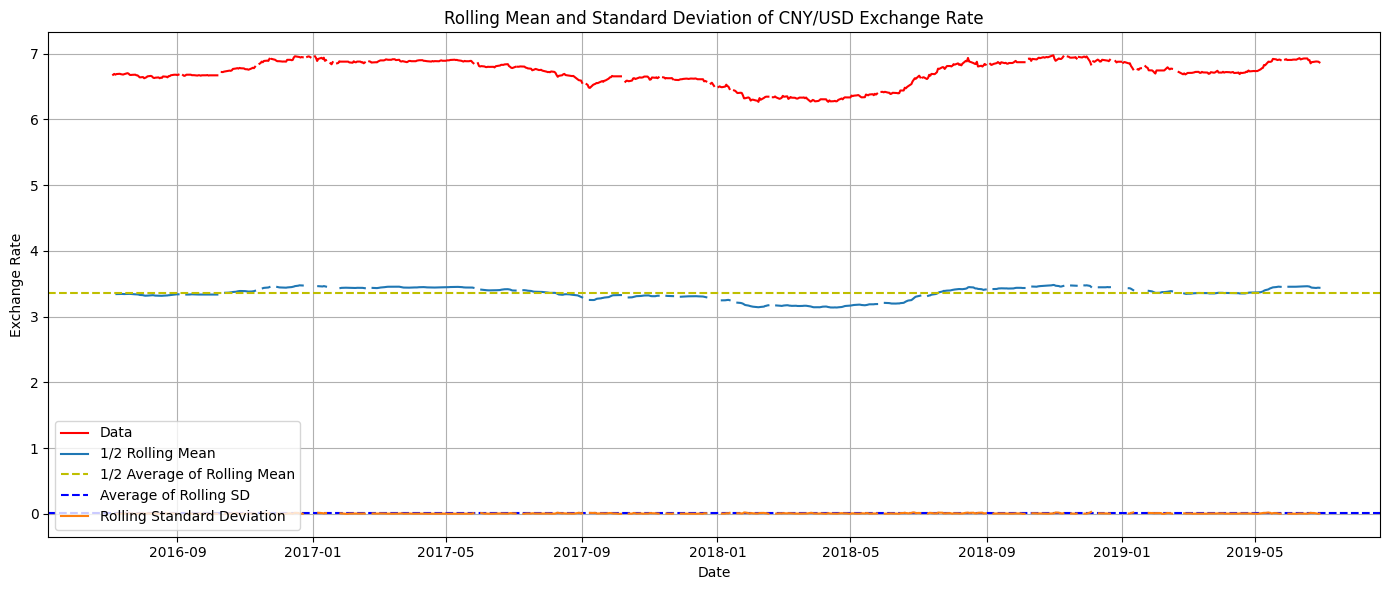

In [ ]:
window_size = 4
rolling_mean = (df_eda['CHINA - YUAN/US$'].rolling(window=window_size).mean()/2)
rolling_std = (df_eda['CHINA - YUAN/US$'].rolling(window=window_size).std()/2)

plt.figure(figsize=(14, 6))
plt.plot(df_eda['CHINA - YUAN/US$'], color='r', label='Data')
plt.plot(rolling_mean, label="1/2 Rolling Mean")
plt.axhline(y=np.mean(rolling_mean), color='y', linestyle='--', label="1/2 Average of Rolling Mean")
plt.axhline(y=np.mean(rolling_std), color='b', linestyle='--', label="Average of Rolling SD")
plt.plot(rolling_std, label="Rolling Standard Deviation")
plt.title('Rolling Mean and Standard Deviation of CNY/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cny_monthly = df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'].asfreq('MS').interpolate(method='linear')

adf_result = adfuller(cny_monthly)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

if adf_result[1] < 0.05:
    print("✅ SGD series are stationary")
else:
    print("❌ SGD series are non-stationary — differencing is needed")

ADF Statistic: -2.2099
p-value: 0.2027
❌ SGD series are non-stationary — differencing is needed


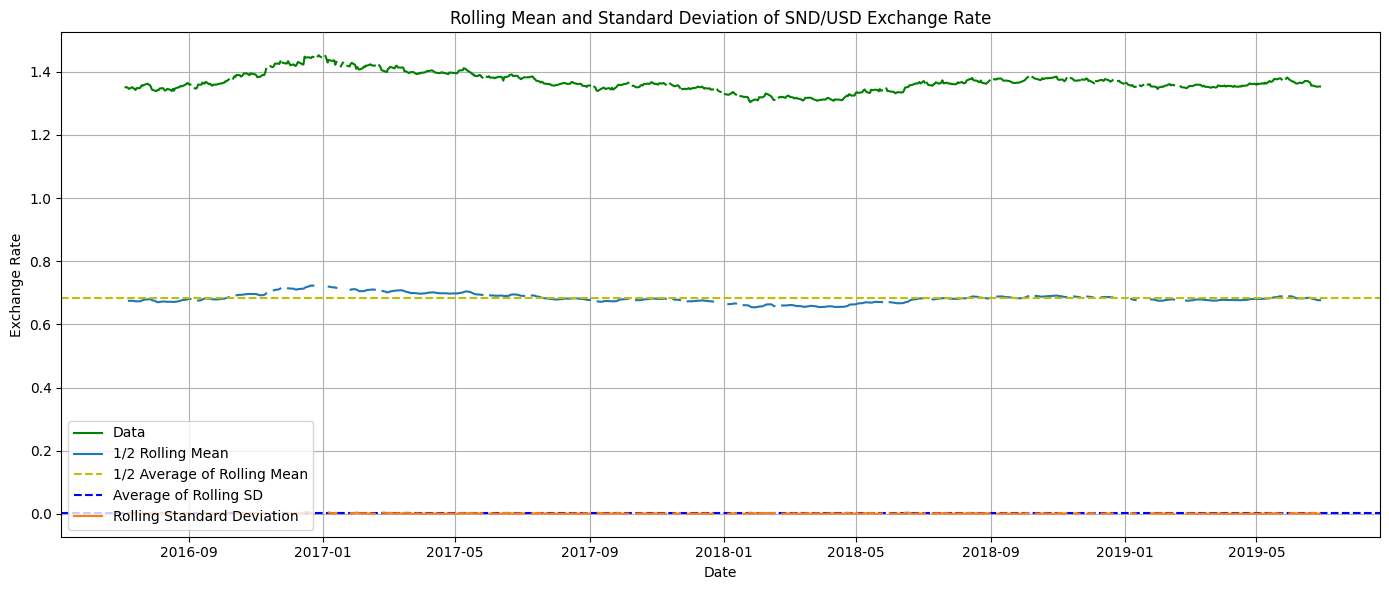

In [ ]:
window_size = 4
rolling_mean = (df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'].rolling(window=window_size).mean()/2)
rolling_std = (df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'].rolling(window=window_size).std()/2)

plt.figure(figsize=(14, 6))
plt.plot(df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'], color='green', label='Data')
plt.plot(rolling_mean, label="1/2 Rolling Mean")
plt.axhline(y=np.mean(rolling_mean), color='y', linestyle='--', label="1/2 Average of Rolling Mean")
plt.axhline(y=np.mean(rolling_std), color='b', linestyle='--', label="Average of Rolling SD")
plt.plot(rolling_std, label="Rolling Standard Deviation")
plt.title('Rolling Mean and Standard Deviation of SND/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gc.collect()

4430

--------------------------------------------------------------------------------

# Predictions

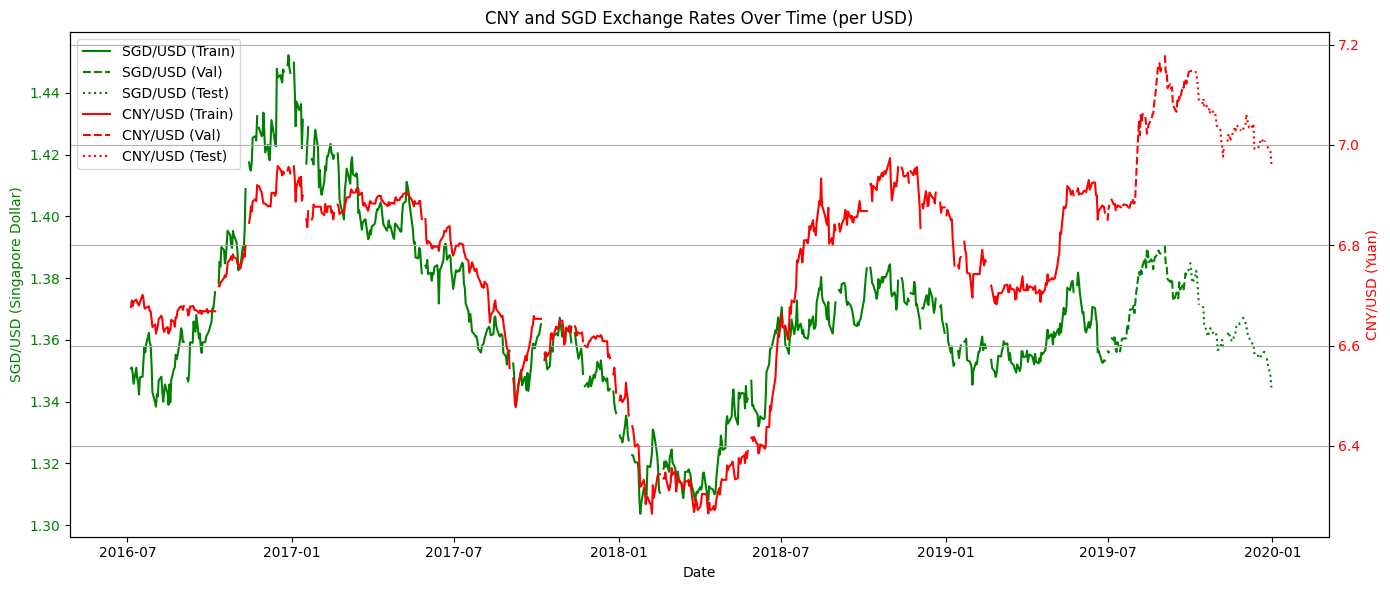

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- SGD/USD ---
color_sgd = 'green'
ax1.set_xlabel('Date')
ax1.set_ylabel('SGD/USD (Singapore Dollar)', color=color_sgd)

# Train
ax1.plot(df_eda.index, df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'],
         color=color_sgd, label='SGD/USD (Train)')

# Validation
ax1.plot(df_val.index, df_val['SINGAPORE - SINGAPORE DOLLAR/US$'],
         color=color_sgd, linestyle='--', label='SGD/USD (Val)')

# Test
ax1.plot(df_test.index, df_test['SINGAPORE - SINGAPORE DOLLAR/US$'],
         color=color_sgd, linestyle=':', label='SGD/USD (Test)')

ax1.tick_params(axis='y', labelcolor=color_sgd)

# --- CNY/USD ---
ax2 = ax1.twinx()
color_cny = 'red'
ax2.set_ylabel('CNY/USD (Yuan)', color=color_cny)

# Train
ax2.plot(df_eda.index, df_eda['CHINA - YUAN/US$'],
         color=color_cny, label='CNY/USD (Train)')

# Validation
ax2.plot(df_val.index, df_val['CHINA - YUAN/US$'],
         color=color_cny, linestyle='--', label='CNY/USD (Val)')

# Test
ax2.plot(df_test.index, df_test['CHINA - YUAN/US$'],
         color=color_cny, linestyle=':', label='CNY/USD (Test)')

ax2.tick_params(axis='y', labelcolor=color_cny)

# --- Title, grid, and legend ---
plt.title('CNY and SGD Exchange Rates Over Time (per USD)')
fig.tight_layout()
plt.grid(True)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

It is important to take into account the complexity of the dataset. The reliable portion of the data spans only 3.5 years. From this, I selected three years (from 1 July 2016 to 1 July 2019) as my exploratory data analysis (EDA) set, the subsequent three months (to 1 October 2019) as my model validation set, and finally the period until 1 January 2020 as my test set.

The EDA set concludes precisely at a period of relatively stable and sustained appreciation of the yuan (a seasonal pattern I identified in the preceding two years). The validation set begins during a seasonal phase when the yuan’s value typically experiences a sharp decline, coinciding with the period when the People’s Republic of China (PRC) purchases soybeans from the United States. The test set falls within the autumn months, when the PRC typically imports substantial quantities of crude oil and natural gas from the United States; however, this seasonal demand ends in December, after which the yuan returns to its steady growth trajectory [3, 5].

I deliberately constructed an additional dataset, df_train, which contains both df_eda and df_val, as a model trained solely on EDA-period data should not - and indeed could not - be expected to perform well on the final test period.
 Models built exclusively on the EDA set will be evaluated only to identify which appear most promising. For a comprehensive view of the dataset, please refer to the graph provided above.

In [ ]:
# exploratory data analysis (EDA) - from 1 July 2016 to 1 July 2019
sgd_monthly_eda = df_eda['SINGAPORE - SINGAPORE DOLLAR/US$'].asfreq('MS').interpolate(method='linear') # smoothing monthly
cny_monthly_eda = df_eda['CHINA - YUAN/US$'].asfreq('MS').interpolate(method='linear')

# validation - from 1 July 2019 to 1 October 2019
sgd_monthly_val = df_val['SINGAPORE - SINGAPORE DOLLAR/US$'].asfreq('MS').interpolate(method='linear')
cny_monthly_val = df_val['CHINA - YUAN/US$'].asfreq('MS').interpolate(method='linear')

# EDA + validation - from 1 July 2016 to 1 October 2019
sgd_monthly_train = df['SINGAPORE - SINGAPORE DOLLAR/US$'][(df.index >= '2016-07-01') & (df.index < '2019-10-01')].asfreq('MS').interpolate(method='linear')
cny_monthly_train = df['CHINA - YUAN/US$'][(df.index >= '2016-07-01') & (df.index < '2019-10-01')].asfreq('MS').interpolate(method='linear')

# finally, my test set - until 1 January 2020
sgd_monthly_test = df_test['SINGAPORE - SINGAPORE DOLLAR/US$'].asfreq('MS').interpolate(method='linear')
cny_monthly_test = df_test['CHINA - YUAN/US$'].asfreq('MS').interpolate(method='linear')

In [ ]:
gc.collect()

5686

## pmdarima’s auto_arima

### auto_arima model's suitability testing

In [ ]:
auto_model_train_cny = pm.auto_arima(
    cny_monthly_eda,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

results_train_cny = auto_model_train_cny.fit(cny_monthly_train, disp=False)
print(results_train_cny.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-77.592, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-18.957, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-62.044, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=241.057, Time=0.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-79.621, Time=0.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-81.534, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-2.460, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-83.495, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-6.400, Time=0.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-81.495, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-79.506, Time=0.55 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-85.489, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-33.843, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-83.494, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-81.503, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-56.713, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-76.264, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-83.797, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-85.792, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-83.859, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-81.857, Time=4.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=-83.791, Time=1.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=-83.266, Time=1.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[12]             : AIC=inf, Time=0.70 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 16.840 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  51.692
Date:                Mon, 11 Aug 2025   AIC                            -95.384
Time:                        08:48:46   BIC                            -88.730
Sample:                    07-01-2016   HQIC                           -92.997
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9835      0.395      2.492      0.013       0.210       1.757
ar.L1          1.3850      0.110     12.586      0.000       1.169       1.601
ar.L2         -0.5314      0.114     -4.646      0.0

In [ ]:
best_order_auto_model_train_cny = auto_model_train_cny.order
best_seasonal_order_auto_model_train_cny = auto_model_train_cny.seasonal_order

print(f"Best order: {best_order_auto_model_train_cny}")
print(f"Best seasonal order: {best_seasonal_order_auto_model_train_cny}")

Best order: (2, 0, 0)
Best seasonal order: (0, 0, 0, 12)


In [ ]:
gc.collect()

281

The model selected by pmdarima’s auto_arima will subsequently be applied to my extended dataset (up to 01.01.2020) and validated against the final df_test set.

In [ ]:
val_model_cny = SARIMAX(
    cny_monthly_train,
    order=best_order_auto_model_train_cny,
    seasonal_order=best_seasonal_order_auto_model_train_cny,
    trend='t'
)

results_val_cny = val_model_cny.fit(disp=False)
print(results_val_cny.summary())

                               SARIMAX Results                                
Dep. Variable:       CHINA - YUAN/US$   No. Observations:                   39
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  44.670
Date:                Mon, 11 Aug 2025   AIC                            -81.340
Time:                        08:48:46   BIC                            -74.686
Sample:                    07-01-2016   HQIC                           -78.953
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0006      0.001      0.956      0.339      -0.001       0.002
ar.L1          1.4684      0.116     12.696      0.000       1.242       1.695
ar.L2         -0.4689      0.116     -4.053      0.0

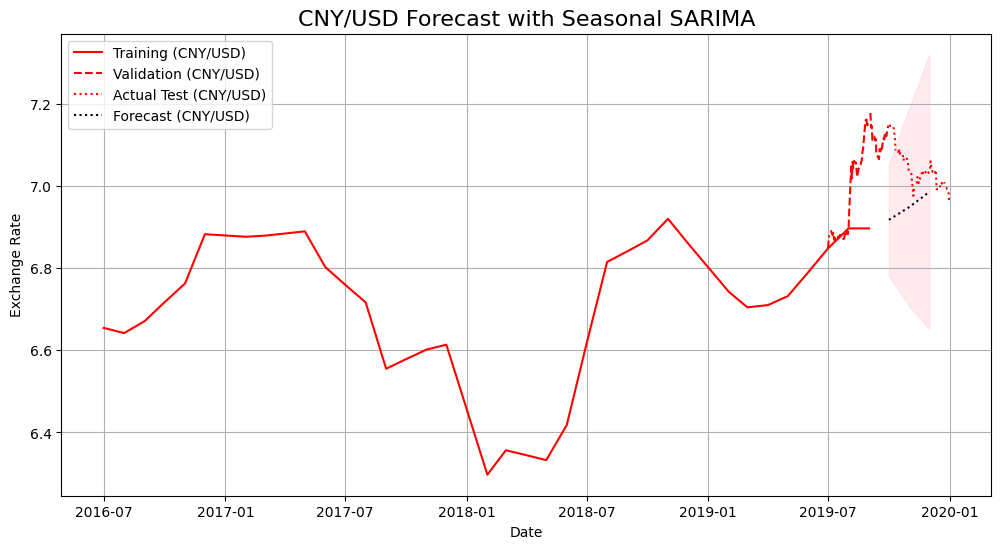

In [ ]:
# Define forecast horizon (2019-10-01 to 2020-01-01)
forecast_steps = len(sgd_monthly_test)
pred_cny_test = results_val_cny.get_forecast(steps=forecast_steps)

# Predicted values & confidence intervals
pred_mean_cny_test = pred_cny_test.predicted_mean
conf_int_cny_test = pred_cny_test.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(cny_monthly_train.index, cny_monthly_train, label='Training (CNY/USD)', color='red')
plt.plot(df_val.index, df_val['CHINA - YUAN/US$'], label='Validation (CNY/USD)', color='red', linestyle='--')
plt.plot(df_test.index, df_test['CHINA - YUAN/US$'], label='Actual Test (CNY/USD)', color='red', linestyle=':')
plt.plot(pred_mean_cny_test.index, pred_mean_cny_test, label='Forecast (CNY/USD)', color='black', linestyle=':')

plt.fill_between(pred_mean_cny_test.index, conf_int_cny_test.iloc[:, 0], conf_int_cny_test.iloc[:, 1], color='pink', alpha=0.3)

plt.title('CNY/USD Forecast with Seasonal SARIMA', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predicted values & confidence intervals
pred_mean_cny_test = pred_cny_test.predicted_mean
conf_int_cny_test = pred_cny_test.conf_int()

# Create comparison DataFrame for the test set
comparison_df_test_yuan = pd.DataFrame({
    'actual': df_test['CHINA - YUAN/US$'],
    'predicted': pred_mean_cny_test
})

# Drop rows with NaN values from both columns
comparison_df_test_yuan.dropna(inplace=True)

# Compute error metrics on the test set
mae_test = mean_absolute_error(
    comparison_df_test_yuan['actual'],
    comparison_df_test_yuan['predicted']
)
rmse_test = np.sqrt(mean_squared_error(
    comparison_df_test_yuan['actual'],
    comparison_df_test_yuan['predicted']
))

# Assuming the exchange rate is around 6.7 CNY/USD
ref_rate = 6.7
mae_pct_test = (mae_test / ref_rate) * 100
rmse_pct_test = (rmse_test / ref_rate) * 100

# Print results for the test set
print(f"MAE on Test Set:  {mae_test:.3f}")
print(f"RMSE on Test Set: {rmse_test:.3f}")
print(f"\n• MAE ≈ {mae_pct_test:.2f}% of rate")
print(f"• RMSE ≈ {rmse_pct_test:.2f}% of rate")

MAE on Test Set:  0.158
RMSE on Test Set: 0.173

• MAE ≈ 2.36% of rate
• RMSE ≈ 2.59% of rate


In [ ]:
gc.collect()

3913

The pmdarima auto_arima model applied in this study has demonstrated notable robustness.
The model was trained using the dataset df_eda, which contains observations up to 1 July 2019, and was subsequently used to forecast a relatively far horizon in three months (from 1 October 2019 to 1 January 2020). Under these unfavourable conditions, the resulting error rate was only 2.5%.
Consequently, if the model were trained appropriately on the most recent available data, its performance would be expected to be sufficiently reliable for potential application in commercial contexts.

### applying the auto arima model

**predicting PRC yuan**

In [ ]:
auto_model_train_cny = pm.auto_arima(
    cny_monthly_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

results_train_cny = auto_model_train_cny.fit(cny_monthly_train, disp=False)
print(results_train_cny.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-82.056, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-20.431, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-82.118, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-64.368, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=261.165, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-84.048, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-82.129, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-80.078, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-95.384, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-93.976, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-94.092, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-91.992, Time=0.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=-93.377, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-93.379, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-94.845, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=-92.735, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 4.844 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  51.692
Date:                Mon, 11 Aug 2025   AIC                            -95.384
Time:                        08:48:52   BIC                            -88.730
Sample:                    07-01-2016   HQIC                           -92.997
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9835      0.395      2.492      0.013       0.210       1.757
ar.L1          1.3850      0.110     12.586      0.000       1.169       1.601
ar.L2         -0.5314      0.114     -4.646      0.0

In [ ]:
best_order_auto_model_train_cny = auto_model_train_cny.order
best_seasonal_order_auto_model_train_cny = auto_model_train_cny.seasonal_order

print(f"Best order: {best_order_auto_model_train_cny}")
print(f"Best seasonal order: {best_seasonal_order_auto_model_train_cny}")

Best order: (2, 0, 0)
Best seasonal order: (0, 0, 0, 12)


In [ ]:
val_model_cny = SARIMAX(
    cny_monthly_train,
    order=best_order_auto_model_train_cny,
    seasonal_order=best_seasonal_order_auto_model_train_cny,
    trend='t'
)

results_val_cny = val_model_cny.fit(disp=False)
print(results_val_cny.summary())

                               SARIMAX Results                                
Dep. Variable:       CHINA - YUAN/US$   No. Observations:                   39
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  44.670
Date:                Mon, 11 Aug 2025   AIC                            -81.340
Time:                        08:48:52   BIC                            -74.686
Sample:                    07-01-2016   HQIC                           -78.953
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0006      0.001      0.956      0.339      -0.001       0.002
ar.L1          1.4684      0.116     12.696      0.000       1.242       1.695
ar.L2         -0.4689      0.116     -4.053      0.0

In [ ]:
gc.collect()

269

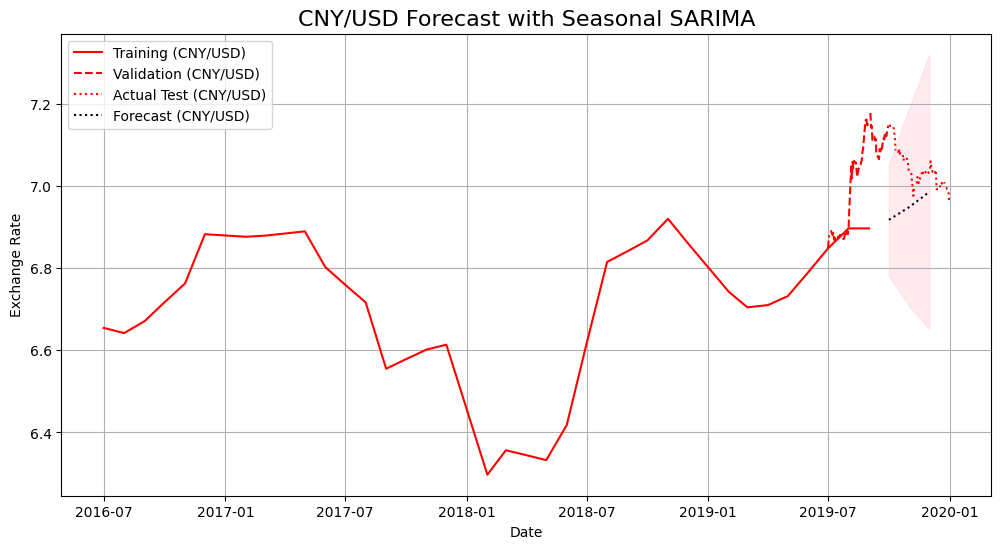

In [ ]:
# Define forecast horizon (2019-10-01 to 2020-01-01)
forecast_steps = len(sgd_monthly_test)
pred_cny_test = results_val_cny.get_forecast(steps=forecast_steps)

pred_mean_cny_test = pred_cny_test.predicted_mean
conf_int_cny_test = pred_cny_test.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(cny_monthly_train.index, cny_monthly_train, label='Training (CNY/USD)', color='red')
plt.plot(df_val.index, df_val['CHINA - YUAN/US$'], label='Validation (CNY/USD)', color='red', linestyle='--')
plt.plot(df_test.index, df_test['CHINA - YUAN/US$'], label='Actual Test (CNY/USD)', color='red', linestyle=':')
plt.plot(pred_mean_cny_test.index, pred_mean_cny_test, label='Forecast (CNY/USD)', color='black', linestyle=':')

plt.fill_between(pred_mean_cny_test.index, conf_int_cny_test.iloc[:, 0], conf_int_cny_test.iloc[:, 1], color='pink', alpha=0.3)

plt.title('CNY/USD Forecast with Seasonal SARIMA', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred_mean_cny_test = pred_cny_test.predicted_mean
conf_int_cny_test = pred_cny_test.conf_int()

comparison_df_test_yuan = pd.DataFrame({
    'actual': df_test['CHINA - YUAN/US$'],
    'predicted': pred_mean_cny_test
})

comparison_df_test_yuan.dropna(inplace=True)

mae_test = mean_absolute_error(
    comparison_df_test_yuan['actual'],
    comparison_df_test_yuan['predicted']
)
rmse_test = np.sqrt(mean_squared_error(
    comparison_df_test_yuan['actual'],
    comparison_df_test_yuan['predicted']
))

# Assuming the exchange rate is around 6.7 CNY/USD
ref_rate = 6.7
mae_pct_test = (mae_test / ref_rate) * 100
rmse_pct_test = (rmse_test / ref_rate) * 100

print(f"MAE on Test Set:  {mae_test:.3f}")
print(f"RMSE on Test Set: {rmse_test:.3f}")
print(f"\n• MAE ≈ {mae_pct_test:.2f}% of rate")
print(f"• RMSE ≈ {rmse_pct_test:.2f}% of rate")

MAE on Test Set:  0.158
RMSE on Test Set: 0.173

• MAE ≈ 2.36% of rate
• RMSE ≈ 2.59% of rate


**predicting Singapore dollar**

predicting straight from US dollar

In [ ]:
auto_model_train_sgd = pm.auto_arima(
    sgd_monthly_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

results_train_sgd = auto_model_train_sgd.fit(sgd_monthly_train, disp=False)
print(results_train_sgd.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-232.646, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-169.242, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=136.916, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-234.937, Time=2.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-236.819, Time=1.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-237.166, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-235.044, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-233.109, Time=0.65 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-222.725, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-236.702, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-236.110, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-205.511, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=-234.066, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-240.024, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-150.789, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-238.774, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-235.132, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-240.395, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-192.071, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-238.494, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-236.471, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-232.479, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=-239.256, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=-236.759, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 13.852 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 124.198
Date:                Mon, 11 Aug 2025   AIC                           -240.395
Time:                        08:49:06   BIC                           -233.741
Sample:                    07-01-2016   HQIC                          -238.008
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2013      0.127      1.580      0.114      -0.048       0.451
ar.L1          1.3286      0.128     10.366      0.000       1.077       1.580
ar.L2         -0.4762      0.192     -2.481      0.0

In [ ]:
best_order_auto_model_train_sgd = auto_model_train_sgd.order
best_seasonal_order_auto_model_train_sgd = auto_model_train_sgd.seasonal_order

print(f"Best order: {best_order_auto_model_train_sgd}")
print(f"Best seasonal order: {best_seasonal_order_auto_model_train_sgd}")

Best order: (2, 0, 0)
Best seasonal order: (0, 0, 0, 12)


In [ ]:
val_model_sgd = SARIMAX(
    sgd_monthly_train,
    order=best_order_auto_model_train_sgd,
    seasonal_order=best_seasonal_order_auto_model_train_sgd,
    trend='t'
)

results_val_sgd = val_model_sgd.fit(disp=False)
print(results_val_sgd.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                      SARIMAX Results                                       
Dep. Variable:     SINGAPORE - SINGAPORE DOLLAR/US$   No. Observations:                   39
Model:                             SARIMAX(2, 0, 0)   Log Likelihood                  93.486
Date:                              Mon, 11 Aug 2025   AIC                           -178.972
Time:                                      08:49:06   BIC                           -172.318
Sample:                                  07-01-2016   HQIC                          -176.585
                                       - 09-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.000      0.566      0.571      -0.000       0.001
ar.L1          0.01

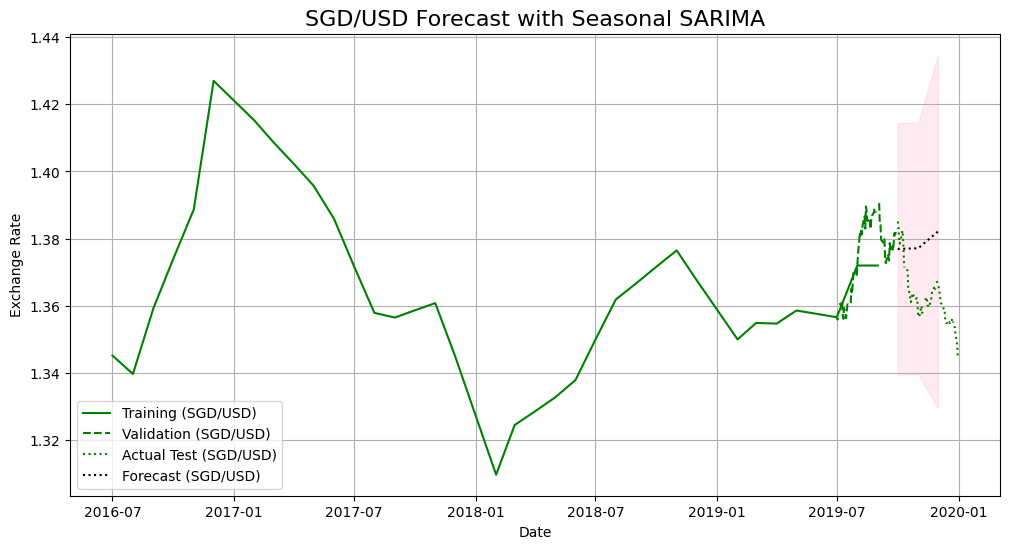

In [ ]:
# Define forecast horizon (2019-10-01 to 2020-01-01)
forecast_steps = len(sgd_monthly_test)
pred_sgd_test = results_val_sgd.get_forecast(steps=forecast_steps)

pred_mean_sgd_test = pred_sgd_test.predicted_mean
conf_int_sgd_test = pred_sgd_test.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(sgd_monthly_train.index, sgd_monthly_train, label='Training (SGD/USD)', color='green')
plt.plot(df_val.index, df_val['SINGAPORE - SINGAPORE DOLLAR/US$'], label='Validation (SGD/USD)', color='green', linestyle='--')
plt.plot(df_test.index, df_test['SINGAPORE - SINGAPORE DOLLAR/US$'], label='Actual Test (SGD/USD)', color='green', linestyle=':')
plt.plot(pred_mean_sgd_test.index, pred_mean_sgd_test, label='Forecast (SGD/USD)', color='black', linestyle=':')

plt.fill_between(pred_mean_sgd_test.index, conf_int_sgd_test.iloc[:, 0], conf_int_sgd_test.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SGD/USD Forecast with Seasonal SARIMA', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred_mean_sgd_test = pred_sgd_test.predicted_mean
conf_int_sgd_test = pred_sgd_test.conf_int()

comparison_df_test_sgd = pd.DataFrame({
    'actual': df_test['SINGAPORE - SINGAPORE DOLLAR/US$'],
    'predicted': pred_mean_sgd_test
})

comparison_df_test_sgd.dropna(inplace=True)

mae_test = mean_absolute_error(
    comparison_df_test_sgd['actual'],
    comparison_df_test_sgd['predicted']
)
rmse_test = np.sqrt(mean_squared_error(
    comparison_df_test_sgd['actual'],
    comparison_df_test_sgd['predicted']
))

# Assuming the exchange rate is around 1.35 SGD/USD
ref_rate = 1.35
mae_pct_test = (mae_test / ref_rate) * 100
rmse_pct_test = (rmse_test / ref_rate) * 100

print(f"MAE on Test Set:  {mae_test:.3f}")
print(f"RMSE on Test Set: {rmse_test:.3f}")
print(f"\n• MAE ≈ {mae_pct_test:.2f}% of rate")
print(f"• RMSE ≈ {rmse_pct_test:.2f}% of rate")

MAE on Test Set:  0.014
RMSE on Test Set: 0.016

• MAE ≈ 1.06% of rate
• RMSE ≈ 1.15% of rate


In [ ]:
gc.collect()

4114

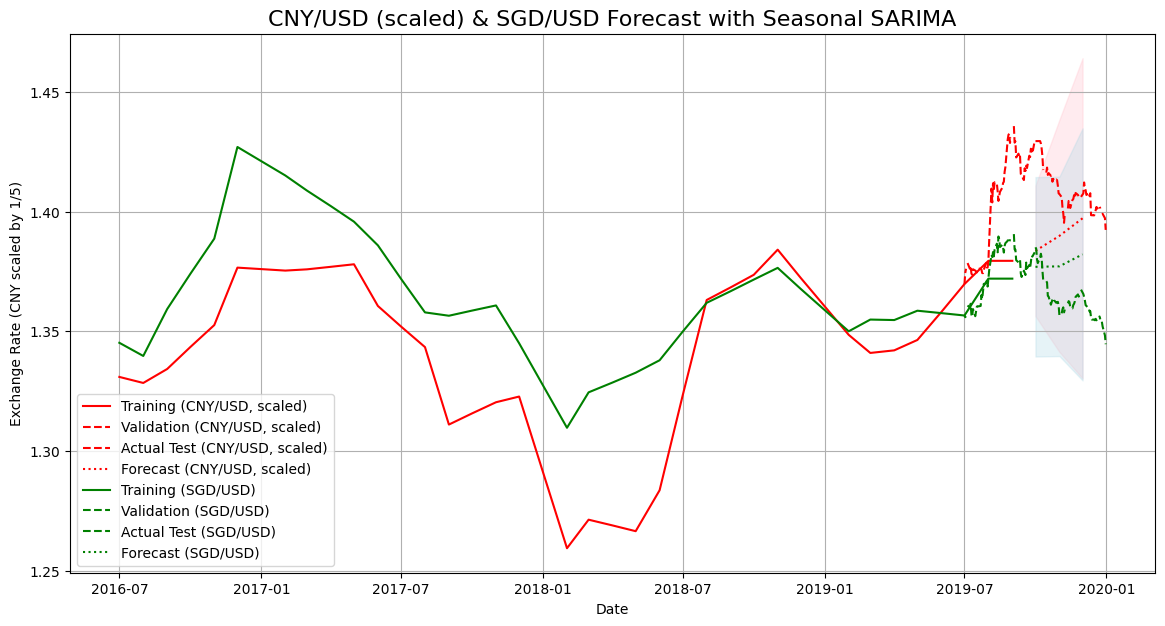

In [ ]:
# Forecasts
forecast_steps = len(sgd_monthly_test)

# --- CNY forecast ---
pred_cny_test = results_val_cny.get_forecast(steps=forecast_steps)
pred_mean_cny_test = pred_cny_test.predicted_mean
conf_int_cny_test = pred_cny_test.conf_int()

# --- SGD forecast ---
pred_sgd_test = results_val_sgd.get_forecast(steps=forecast_steps)
pred_mean_sgd_test = pred_sgd_test.predicted_mean
conf_int_sgd_test = pred_sgd_test.conf_int()

# --- Plot ---
plt.figure(figsize=(14, 7))

# CNY scaled to 1/5
scale_factor = 5

plt.plot(cny_monthly_train.index, cny_monthly_train / scale_factor,
         label='Training (CNY/USD, scaled)', color='red')
plt.plot(df_val.index, df_val['CHINA - YUAN/US$'] / scale_factor,
         label='Validation (CNY/USD, scaled)', color='red', linestyle='--')
plt.plot(df_test.index, df_test['CHINA - YUAN/US$'] / scale_factor,
         label='Actual Test (CNY/USD, scaled)', color='red', linestyle='--')
plt.plot(pred_mean_cny_test.index, pred_mean_cny_test / scale_factor,
         label='Forecast (CNY/USD, scaled)', color='red', linestyle=':')

plt.fill_between(pred_mean_cny_test.index,
                 conf_int_cny_test.iloc[:, 0] / scale_factor,
                 conf_int_cny_test.iloc[:, 1] / scale_factor,
                 color='pink', alpha=0.3)

# SGD unscaled
plt.plot(sgd_monthly_train.index, sgd_monthly_train,
         label='Training (SGD/USD)', color='green')
plt.plot(df_val.index, df_val['SINGAPORE - SINGAPORE DOLLAR/US$'],
         label='Validation (SGD/USD)', color='green', linestyle='--')
plt.plot(df_test.index, df_test['SINGAPORE - SINGAPORE DOLLAR/US$'],
         label='Actual Test (SGD/USD)', color='green', linestyle='--')
plt.plot(pred_mean_sgd_test.index, pred_mean_sgd_test,
         label='Forecast (SGD/USD)', color='green', linestyle=':')

plt.fill_between(pred_mean_sgd_test.index,
                 conf_int_sgd_test.iloc[:, 0],
                 conf_int_sgd_test.iloc[:, 1],
                 color='lightblue', alpha=0.3)

# Labels
plt.title('CNY/USD (scaled) & SGD/USD Forecast with Seasonal SARIMA', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (CNY scaled by 1/5)')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

I am firmly convinced that for high-value and high-risk applications, a range of distinctly constructed models should be applied concurrently. This approach provides a more reliable estimate of probable scenarios. In my view, greater weight should be assigned to models built on probability theory and historical analysis (such as SARIMAX), while fully automated models should also be included to minimise the risk of human error and misinterpretation [18].

Indeed, I have already identified my own errors through the use of such automated approaches.

# References

1. Goldstein, M., & Lardy, N. R. (2008). China’s Exchange Rate Policy: An Overview of Some Key Issues. Peterson Institute for International Economics.

2. International Monetary Fund (2019). The Future of China’s Exchange Rate Regime. IMF Working Paper No. 19/50.

3. People’s Bank of China (2015). Announcement on Improving the RMB Central Parity Quotation Mechanism. PBoC Official Release.

4. Shu, C., Chow, N., & Chan, J.-Y. (2007). Impact of the Renminbi exchange rate on Asian currencies. China Economic Issues No. 3/07, Hong Kong Monetary Authority.

5. McCauley, R. N., & Shu, C. (2019). Recent renminbi policy and currency co-movements. BIS Working Papers No. 762. Bank for International Settlements.

6. International Monetary Fund (2016). Exchange Rate Co-Movements and the RMB in Asia. IMF Working Paper WP/16/165.

7. Monetary Authority of Singapore (2020). Monetary Policy Operations in Singapore.

8. Soybean Seasonal Trends in the PRC Import Market, Commodity Analysis Report (Seasonax): Seasonal losses observed between late June and early October, averaging –4.87% over 15 years
seasonax.

9. Understanding Seasonality in Grains and Oilseeds, CME Group: Discusses how planting and harvest cycles affect pricing, contributing to seasonal commodity price patterns
CME Group.

10. Board of Governors of the Federal Reserve System – Daily RMB–USD Spot Exchange Rate and WTI Crude Oil Prices via FRED: Enable quantitative analysis of exchange rate movements in relation to energy import shocks
FRED.

11. A case study applying an ARIMA model to forecast the SGD (as part of USD/KZT, EUR/KZT, SGD/KZT pairs) achieved a MAPE of approximately 3.69% for the SGD, highlighting that sub-5 % MAPE is common and considered reasonable in such exchange rate forecasting contexts.

12. In non-financial time series forecasting, a SARIMAX model applied to energy load data recorded a MAPE of 13.2%, while its SARIMAX–GARCH variant reached 11.0 %. This provides a benchmark for modeling complexity and room for improvement using exogenous variables or hybrid techniques
emerginginvestigators.org

13. A review of machine learning and time-series methods in FX prediction confirms that MAPE is one of the primary evaluation metrics, widely used for benchmarking model performance across studies
SpringerOpen

14. Engel, Charles. “The forward discount anomaly and the risk premium: A survey of recent evidence.” Journal of Empirical Finance 3, no. 2-3 (1996): 123-192.
15. Sarno, Lucio, and Mark P. Taylor. “The economics of exchange rates.” Cambridge University Press, 2002.

16. Hyndman, R. J. and Athanasopoulos, G. (2018). Forecasting: Principles and Practice. 2nd ed. Melbourne: OTexts.

17. Enders, W. (2014). Applied Econometric Time Series. 4th ed. Chichester: Wiley.

18. Clemen, R. T. (1989). ‘Combining forecasts: A review and annotated bibliography’, International Journal of Forecasting, 5(4), pp. 559–583.

Project_Finance https://colab.research.google.com/drive/1qeMpOg7vLNO7y1XK27o9UaFxGfY5vJSA?usp=sharing

 Yuan_part2 https://colab.research.google.com/drive/1UL6FthXErH4SUeTS-8AWZ6c97pA9FCFW?usp=sharing